In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.signal import stft


In [2]:
DATA_PATH = "../Data/processed/biomedical_preprocessed.csv"
combined_df = pd.read_csv(DATA_PATH)

print("Loaded shape:", combined_df.shape)


Loaded shape: (3668152, 28)


In [3]:
subject = combined_df["subject_id"].iloc[0]
activity = "walk"   # change to "sit" or "run" later

subset = combined_df[
    (combined_df["subject_id"] == subject) &
    (combined_df["activity"] == activity)
].sort_values("time")


In [4]:
FS = 500  # Hz

ax = subset["a_x"].values
ax = ax - np.mean(ax)   # remove gravity

len(ax)


242888

In [5]:
#stft
f, t, Zxx = stft(
    ax,
    fs=FS,
    nperseg=1024,
    noverlap=512
)

Zxx.shape


(513, 476)

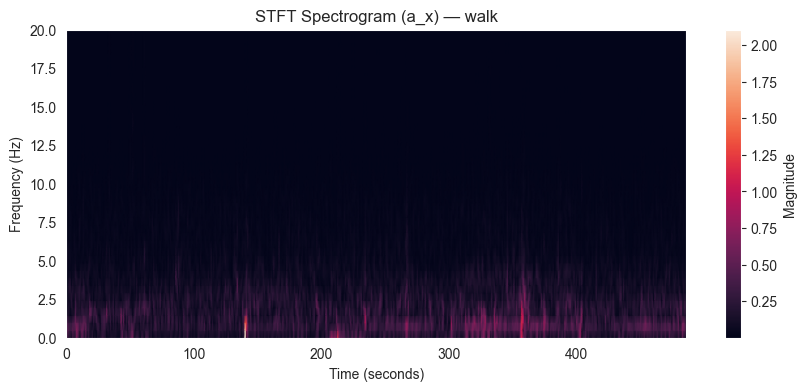

In [6]:
#stft spectogram:
plt.figure(figsize=(10,4))
plt.pcolormesh(t, f, np.abs(Zxx), shading="gouraud")
plt.title(f"STFT Spectrogram (a_x) — {activity}")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
plt.colorbar(label="Magnitude")
plt.ylim(0, 20)   # human motion frequencies
plt.show()


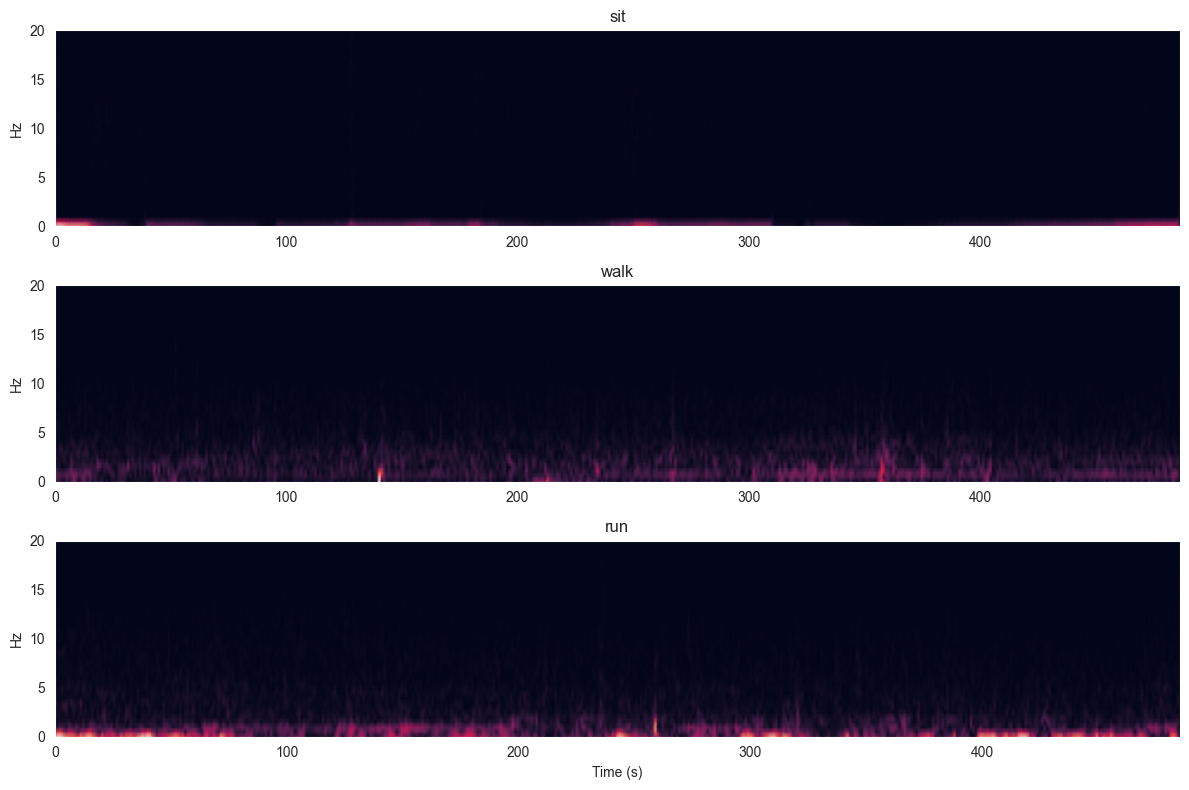

In [7]:
activities = ["sit", "walk", "run"]

plt.figure(figsize=(12,8))

for i, act in enumerate(activities, 1):
    subset = combined_df[
        (combined_df["subject_id"] == subject) &
        (combined_df["activity"] == act)
    ].sort_values("time")

    ax = subset["a_x"].values
    ax = ax - np.mean(ax)

    f, t, Zxx = stft(ax, fs=FS, nperseg=1024, noverlap=512)

    plt.subplot(3,1,i)
    plt.pcolormesh(t, f, np.abs(Zxx), shading="gouraud")
    plt.title(act)
    plt.ylabel("Hz")
    plt.ylim(0, 20)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


In [8]:
import pywt
import numpy as np
import matplotlib.pyplot as plt


In [9]:
subject = combined_df["subject_id"].iloc[0]
activity = "walk"   # change to sit / run later

subset = combined_df[
    (combined_df["subject_id"] == subject) &
    (combined_df["activity"] == activity)
].sort_values("time")

ax = subset["a_x"].values
ax = ax - np.mean(ax)   # gravity removal


In [10]:
#CWT SCALE
scales = np.arange(1, 256)
wavelet = "morl"   # Morlet (standard biomedical choice)


In [11]:
#conpute CWT
coeffs, freqs = pywt.cwt(
    ax,
    scales,
    wavelet,
    sampling_period=1/FS
)

coeffs.shape


(255, 242888)

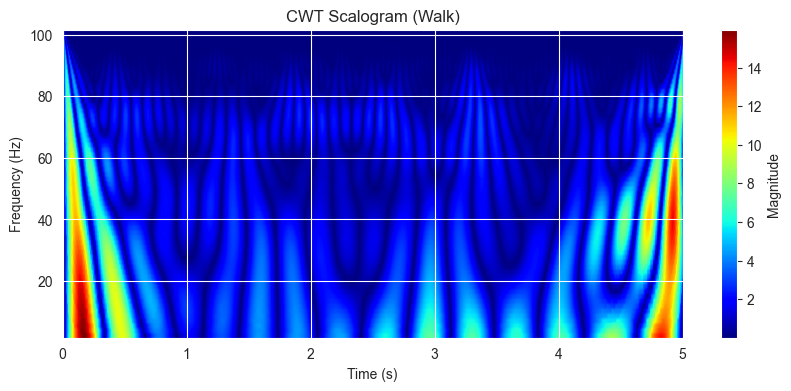

In [15]:
#cwt scalogram
import pywt
import matplotlib.pyplot as plt

# Select ONE subject + ONE activity
sample = combined_df[
    (combined_df["subject_id"] == "s22") &
    (combined_df["activity"] == "walk")
].sort_values("time")

# Take ONLY one window
ax = sample["a_x"].values[:FS*5]

# Downsample to reduce memory
ax = ax[::4]   # 500 Hz → 125 Hz
fs_ds = 125

scales = np.arange(1, 64)

coeffs, freqs = pywt.cwt(
    ax,
    scales,
    "morl",
    sampling_period=1/fs_ds
)

plt.figure(figsize=(10,4))
plt.imshow(
    np.abs(coeffs),
    aspect="auto",
    extent=[0, len(ax)/fs_ds, freqs[-1], freqs[0]],
    cmap="jet"
)
plt.colorbar(label="Magnitude")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("CWT Scalogram (Walk)")
plt.show()



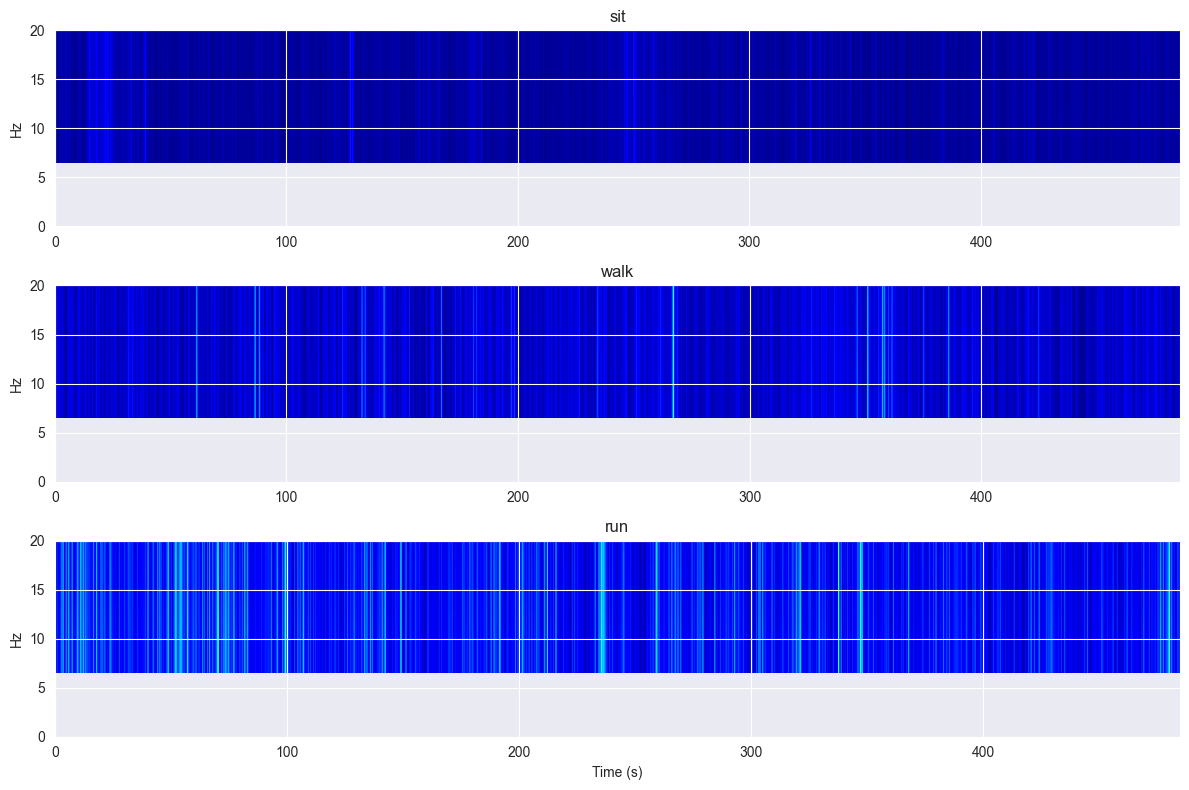

In [16]:
activities = ["sit", "walk", "run"]

plt.figure(figsize=(12,8))

for i, act in enumerate(activities, 1):
    subset = combined_df[
        (combined_df["subject_id"] == subject) &
        (combined_df["activity"] == act)
    ].sort_values("time")

    ax = subset["a_x"].values
    ax = ax - np.mean(ax)

    coeffs, freqs = pywt.cwt(ax, scales, wavelet, sampling_period=1/FS)

    plt.subplot(3,1,i)
    plt.imshow(
        np.abs(coeffs),
        extent=[0, len(ax)/FS, freqs[-1], freqs[0]],
        aspect="auto",
        cmap="jet"
    )
    plt.title(act)
    plt.ylabel("Hz")
    plt.ylim(0, 20)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()
